In [1]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import pymaster as nmt

In [2]:
#Make a small circular mask
nsim = 100
nside = 128
lmax = 3*nside-1

# mask = np.zeros(hp.nside2npix(nside))
# th, ph = hp.pix2ang(nside, np.arange(hp.nside2npix(nside)))

# ph[np.where(ph > np.pi)[0]] -= 2 * np.pi

# mask[np.where(np.sqrt(ph**2+((th-np.pi/2)/1)**2)<np.pi/25)[0]] = 1.
# mask_apo = nmt.mask_apodization(mask, 5, apotype='C1')

# hp.mollview(mask_apo)

In [3]:
def get_mask_analytic(ns, aps, fsk=0.0945, dec0=0., ra0=0.) :
    #This generates a correctly-apodized mask
    DTOR = np.pi/180
    v0=np.array([np.sin(DTOR*(90-dec0))*np.cos(DTOR*ra0),
                 np.sin(DTOR*(90-dec0))*np.sin(DTOR*ra0),
                 np.cos(DTOR*(90-dec0))])
    vv=np.array(hp.pix2vec(ns,np.arange(hp.nside2npix(ns))))
    cth=np.sum(v0[:,None]*vv,axis=0); th=np.arccos(cth); th0=np.arccos(1-2*fsk); th_apo=aps*DTOR
    id0=np.where(th>=th0)[0]
    id1=np.where(th<=th0-th_apo)[0]
    idb=np.where((th>th0-th_apo) & (th<th0))[0]
    x=np.sqrt((1-np.cos(th[idb]-th0))/(1-np.cos(th_apo)))
    mask_apo=np.zeros(hp.nside2npix(ns))
    mask_apo[id0]=0.
    mask_apo[id1]=1.
    mask_apo[idb]=x-np.sin(2*np.pi*x)/(2*np.pi)
    return mask_apo

/scratch/yuyang/conda/envs/toast/lib/python3.8/site-packages/healpy/projaxes.py:920: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_over(newcm(1.0))
/scratch/yuyang/conda/envs/toast/lib/python3.8/site-packages/healpy/projaxes.py:921: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_under(bgcolor)
/scratch/yuyang/conda/envs/toast/lib/python3.8/site-packages/healpy/projaxes.py:922: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, 

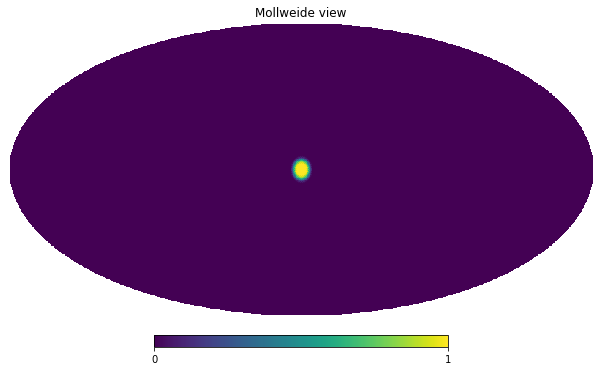

In [4]:
msk_apo = get_mask_analytic(nside, 5., fsk=0.0945/22.7)
# Binary mask
msk_bin = np.ones_like(msk_apo)
msk_bin[msk_apo <= 0] = 0
hp.mollview(msk_apo)

In [5]:
#check derivatives of mask
# def der1(m):
#     nside = hp.get_nside(m)
#     lmax = 3*nside-1
#     alm_orig = hp.map2alm(m, lmax)
#     m_orig, dtheta, dphi = hp.alm2map_der1(alm_orig, nside, lmax)
#     return m_orig, dtheta, dphi

# m, dtheta, dphi = der1(msk_apo)
# m, dtheta2, dthetaphi = der1(dtheta)
# m, dphitheta, dphi2 = der1(dphi)

# lon,lat = hp.pix2ang(nside, np.argmax(msk), lonlat=True)
# hp.gnomview(dphi2, rot=(lon+5, lat-10), xsize=800, reso=5)

In [6]:
#Binning, and load Dls (just from CAMB with r=0.01)

b = nmt.NmtBin.from_nside_linear(nside, 32)
leff = b.get_effective_ells()
l, cltt, clee, clbb, clte = np.loadtxt('totcls_lensed_r0p1.txt', unpack=True)

#Turn into Cl
prefactor = 2*np.pi/(l*(l+1))
prefactor[0] = 0.

cltt *= prefactor
clee *= prefactor
clbb *= prefactor
clte *= prefactor

cl_th = np.array([clee, np.zeros_like(clee), np.zeros_like(clee), clbb])

<ipython-input-6-a7cdef9c6447>:8: RuntimeWarning: divide by zero encountered in true_divide
  prefactor = 2*np.pi/(l*(l+1))


In [12]:
def get_fields():
    mp_t, mp_q, mp_u = hp.synfast([cltt, clee, clbb, clte], nside=nside, lmax=lmax, new=True, verbose=False)    
    # This creates a spin-2 field without purifying either E or B
    f2_np = nmt.NmtField(msk_apo, [mp_q, mp_u])
    # This creates a spin-2 field with both pure E and B.
    f2_yp = nmt.NmtField(msk_apo, [mp_q, mp_u], purify_b=True, n_iter_mask_purify=3)
    # Note that generally it's not a good idea to purify both,
    # since you'll lose sensitivity on E
    return f2_np, f2_yp

In [13]:
f2np0, f2yp0 = get_fields()
w_np = nmt.NmtWorkspace()
w_np.compute_coupling_matrix(f2np0, f2np0, b)
w_yp = nmt.NmtWorkspace()
w_yp.compute_coupling_matrix(f2yp0, f2yp0, b)

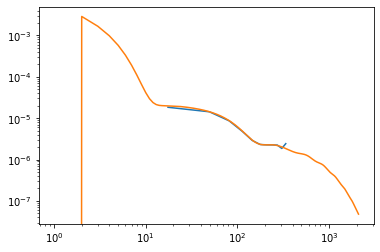

In [14]:
cl_th_binned = w_yp.decouple_cell(w_yp.couple_cell(cl_th))
plt.loglog(leff, cl_th_binned[3])
plt.loglog(l, clbb)

In [15]:
def compute_master(f_a, f_b, wsp):
    cl_coupled = nmt.compute_coupled_cell(f_a, f_b)
    cl_decoupled = wsp.decouple_cell(cl_coupled)
    return cl_decoupled

In [16]:
data_np = []
data_yp = []
for i in np.arange(nsim):
    #print(i, nsim)
    fnp, fyp = get_fields()
    data_np.append(compute_master(fnp, fnp, w_np))
    data_yp.append(compute_master(fyp, fyp, w_yp))
data_np = np.array(data_np)
data_yp = np.array(data_yp)

clnp_mean = np.mean(data_np, axis=0)
clnp_std = np.std(data_np, axis=0)
clyp_mean = np.mean(data_yp, axis=0)
clyp_std = np.std(data_yp, axis=0)

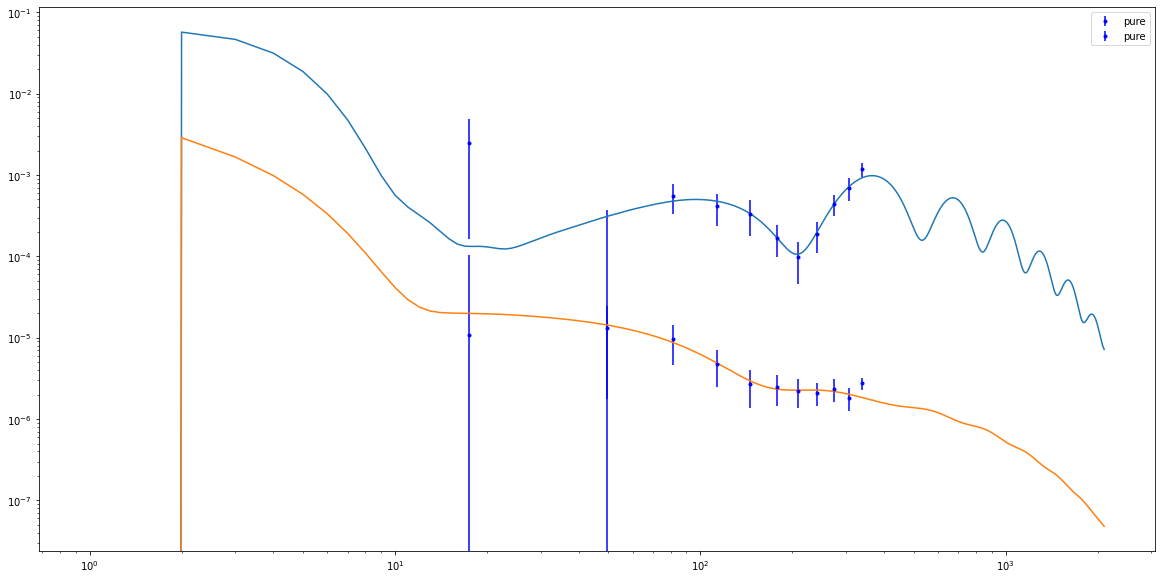

In [28]:
# Now we plot the results
prefactor = leff*(leff+1)/2/np.pi

plt.figure(figsize=(20,10))
#plt.errorbar(leff, prefactor*clnp_mean[3], yerr=prefactor*clnp_std[3], fmt='r.',label='output')
plt.errorbar(leff, clyp_mean[3], yerr=clyp_std[3], fmt='b.',label='pure')
plt.errorbar(leff, clyp_mean[0], yerr=clyp_std[0], fmt='b.',label='pure')

# plt.plot(leff, cl_th_binned[3], label='binned')
# plt.plot(leff, cl_th_binned[0], label='binned')

plt.plot(l, cl_th[0])
plt.plot(l, cl_th[3])

plt.yscale('log')
plt.xscale('log')
plt.legend()